In [8]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from numba import jit

from aRead import *
import constants as c

matplotlib.rcParams['figure.dpi'] = 150

In [ ]:
# Load snapshot data
data1 = readAREPO("/UV1/cloudUV1_018.hdf5", 1)
data10 = readAREPO("/UV10/cloudUV10_024.hdf5", 1)
data100 = readAREPO("/UV100/cloudUV100_037.hdf5", 1)
data1000 = readAREPO("/UV1000/cloudUV1000_041.hdf5", 1)

In [ ]:
data12 = readAREPO("/UV1r2/cloudUV1_019.hdf5", 1)
data102 = readAREPO("/UV10r2/cloudUV10_030.hdf5", 1)
data1002 = readAREPO("/UV100r2/cloudUV100_057.hdf5", 1)
data10002 = readAREPO("/UV1000r2/cloudUV1000_051.hdf5", 1)

In [6]:
print(np.sum(0.5 * data1.mass * (data1.vx**2 + data1.vy**2 + data1.vz**2)))
print(np.sum(0.5 * data10.mass * (data10.vx**2 + data10.vy**2 + data10.vz**2)))
print(np.sum(0.5 * data100.mass * (data100.vx**2 + data100.vy**2 + data100.vz**2)))
print(np.sum(0.5 * data1000.mass * (data1000.vx**2 + data1000.vy**2 + data1000.vz**2)))

print(np.sum(0.5 * data12.mass * (data12.vx**2 + data12.vy**2 + data12.vz**2)))
print(np.sum(0.5 * data102.mass * (data102.vx**2 + data102.vy**2 + data102.vz**2)))
print(np.sum(0.5 * data1002.mass * (data1002.vx**2 + data1002.vy**2 + data1002.vz**2)))
print(np.sum(0.5 * data10002.mass * (data10002.vx**2 + data10002.vy**2 + data10002.vz**2)))

5.996968258855818e+47
5.786556327632154e+47
1.3314301560386602e+48
1.0936799046282067e+49
5.353291787167875e+47
4.855192244103547e+47
2.3858267245360148e+48
1.406865787735051e+49


In [3]:
def eKinAndTherm(data):
    # Create bins of number density
    bins = 10**np.linspace(-1, 8, 50)

    # Create arrays
    binKE = np.zeros_like(bins)
    binTE = np.zeros_like(bins)
    binGPE = np.zeros_like(bins)
    binVelDisp = np.zeros_like(bins)

    for i in range(len(bins)-1):
        inBin = np.where((data.numberDensity > bins[i]) & (data.numberDensity <= bins[i+1]))
        
        binKE[i] = np.sum(0.5 * data.mass[inBin] * (data.vx[inBin]**2 + data.vy[inBin]**2 + data.vz[inBin]**2))
        binTE[i] = np.sum(data.u[inBin] * data.mass[inBin])#np.sum(0.5 * data1.mass[inBin] * (2 * 1.38e-16 * data1.gasTemp[inBin] / (2.4 * 1.66e-24)))
        binGPE[i] = np.sum(-1*data.potential[inBin] * c.uEnergy())
        
        vxMean = np.mean(data.vx[inBin])
        vyMean = np.mean(data.vy[inBin])
        vzMean = np.mean(data.vz[inBin])
        
        binVelDisp[i] = np.sqrt(np.sum((data.vx[inBin]-vxMean)**2 + (data.vy[inBin] - vyMean)**2 + (data.vz[inBin] - vzMean)**2) / len(data.vx[inBin]))
    
    return bins, binKE, binTE, binGPE, binVelDisp

In [43]:
bins, k1, t1, g1, v1 = eKinAndTherm(data1)
bins, k10, t10, g10, v10 = eKinAndTherm(data10)
bins, k100, t100, g100, v100 = eKinAndTherm(data100)
bins, k1000, t1000, g1000, v1000 = eKinAndTherm(data1000)

Text(0, 0.5, 'Velocity Dispersion')

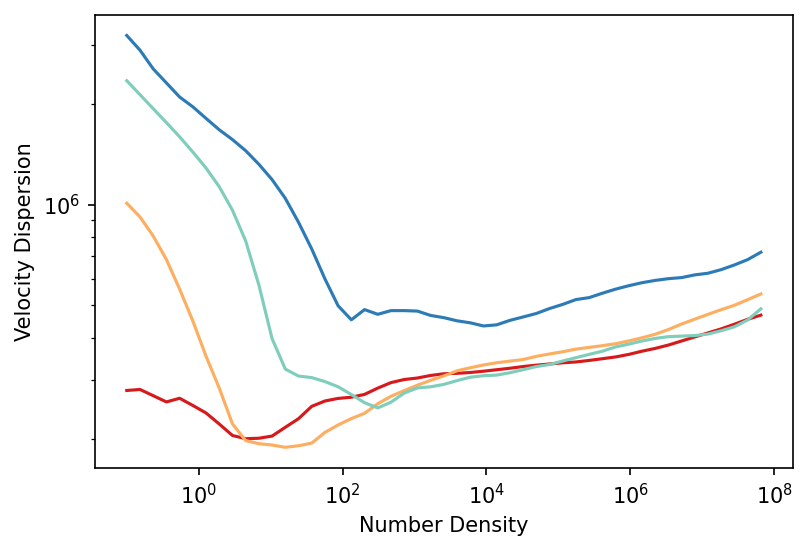

In [44]:
plt.figure(figsize=(6,4))
#plt.plot(bins[:-1], k1[:-1]/t1[:-1], c.colours()[0])
#plt.plot(bins[:-1], k10[:-1]/t10[:-1], c.colours()[1])
#plt.plot(bins[:-1], k100[:-1]/t100[:-1], c.colours()[3])
#plt.plot(bins[:-1], k1000[:-1]/t1000[:-1], c.colours()[4])

plt.plot(bins[:-1], v1[:-1], c.colours()[0])
plt.plot(bins[:-1], v10[:-1], c.colours()[1])
plt.plot(bins[:-1], v100[:-1], c.colours()[3])
plt.plot(bins[:-1], v1000[:-1], c.colours()[4])

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number Density")
plt.ylabel("Velocity Dispersion")

In [3]:
# Function to get velocity dispersions around peaks
@jit(nopython=True)
def getPeakVelocityDispersions(x, y, z, vx, vy, vz, mass, rho, gasTemp, maxPotential):
    # Locate the peaks
    peaks = np.where(maxPotential == 1)[0]
    peakX = x[peaks]
    peakY = y[peaks]
    peakZ = z[peaks]
    peakRho = rho[peaks]
    peakTemp = gasTemp[peaks]
    
    # Work out Jeans length there
    peakJeans = np.sqrt(15 * 1.38e-16 * peakTemp / (4 * np.pi * 6.67e-8 * peakRho * 2.4 * 1.66e-24))
    
    # Create arrays
    peakVelDisp = np.zeros_like(peakJeans)
    
    peakKE = np.zeros_like(peakJeans)
    peakTE = np.zeros_like(peakJeans)
    peakGPE = np.zeros_like(peakJeans)

    # Loop through peaks
    for i in range(len(peakJeans)):
        # Find distance to this peak
        dPeak = np.sqrt((peakX[i] - x)**2 + (peakY[i] - y)**2 + (peakZ[i] - z)**2)
        
        vxJ = vx[dPeak <= 2*peakJeans[i]] - vx[peaks[i]]
        vyJ = vy[dPeak <= 2*peakJeans[i]] - vy[peaks[i]]
        vzJ = vz[dPeak <= 2*peakJeans[i]] - vz[peaks[i]]
        
        vxBar = np.mean(vxJ)
        vyBar = np.mean(vyJ)
        vzBar = np.mean(vzJ)
        
        peakVelDisp[i] = np.sqrt(np.sum((vxJ-vxBar)**2 + (vyJ-vyBar)**2 + (vzJ-vzBar)**2) / len(vxJ))
        
        peakKE[i] = np.sum(0.5 * mass[dPeak <= 2*peakJeans[i]] * )
        
        
    
    return peakJeans, peakVelDisp

SyntaxError: invalid syntax (1028604127.py, line 37)

In [ ]:
j1, v1 = getPeakVelocityDispersions(data1.x, data1.y, data1.z, data1.vx, data1.vy, data1.vz, data1.mass, data1.rho, data1.gasTemp, data1.maxPotential)
j10, v10 = getPeakVelocityDispersions(data10.x, data10.y, data10.z, data10.vx, data10.vy, data10.vz, data10.mass, data10.rho, data10.gasTemp, data10.maxPotential)
j100, v100 = getPeakVelocityDispersions(data100.x, data100.y, data100.z, data100.vx, data100.vy, data100.vz, data100.mass, data100.rho, data100.gasTemp, data100.maxPotential)
j1000, v1000 = getPeakVelocityDispersions(data1000.x, data1000.y, data1000.z, data1000.vx, data1000.vy, data1000.vz, data1000.mass, data1000.rho, data1000.gasTemp, data1000.maxPotential)

Text(0, 0.5, 'Frequency Density')

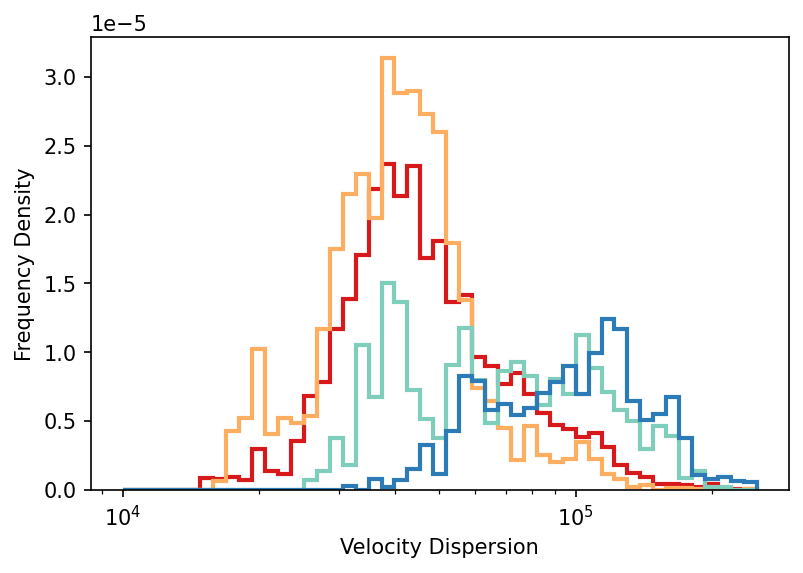

In [18]:
bins = 10**np.linspace(4, 5.4, 50)

plt.figure(figsize=(6,4))
h = plt.hist(v1, bins=bins, color=c.colours()[0], density=True, histtype="step", linewidth=2)
h = plt.hist(v10, bins=bins, color=c.colours()[1], density=True, histtype="step", linewidth=2)
h = plt.hist(v100, bins=bins, color=c.colours()[3], density=True, histtype="step", linewidth=2)
h = plt.hist(v1000, bins=bins, color=c.colours()[4], density=True, histtype="step", linewidth=2)
plt.xscale("log")

plt.xlabel("Velocity Dispersion")
plt.ylabel("Frequency Density")

In [4]:
@jit(nopython=True)
def findVirialParamOfPeaks(maxPotential, temp, density, x, y, z, vx, vy, vz, mass, u):
    # Find the peaks
    peaks = np.where(maxPotential == 1)[0]
    
    # Find the Jeans length at the peaks
    peakJeans = np.sqrt(15 * 1.38e-16 * temp[peaks] / (4 * np.pi * 6.67e-8 * density[peaks] * 2.4 * 1.66e-24))
    
    # Extract the peak properties
    peakX = x[peaks]
    peakY = y[peaks]
    peakZ = z[peaks]
    peakVX = vx[peaks]
    peakVY = vy[peaks]
    peakVZ = vz[peaks]
    
    # Create arrays to store
    peakKE = np.zeros_like(peakX)
    peakTE = np.zeros_like(peakX)
    peakGPE = np.zeros_like(peakX)
    
    # Loop through each peak to find its energies
    for i in range(200):
        # Find particles in the peak Jeans length
        dPeak = (x - peakX[i])**2 + (y - peakY[i])**2 + (z - peakZ[i])**2
        inPeak = []
        
        for j in range(len(x)):
            if dPeak[j] <= peakJeans[i]**2:
                inPeak.append(j)
        inPeak = np.array(inPeak)
                
        # Calculate KE and TE
        peakKE[i] = np.sum(0.5 * mass[inPeak] * ((vx[inPeak] - peakVX[i])**2 + (vy[inPeak] - peakVY[i])**2 + (vz[inPeak] - peakVZ[i])**2))
        peakTE[i] = np.sum(u[inPeak] * mass[inPeak])
        
        # Calculate GPE
        gpe = 0
        for j in range(1,len(inPeak)):
            for k in range(len(inPeak)):
                if j == k:
                    pass
                else:
                    dr = np.sqrt((x[inPeak[j]] - x[inPeak[k]])**2 + (y[inPeak[j]] - y[inPeak[k]])**2 + (z[inPeak[j]] - z[inPeak[k]])**2)
                    gpe += mass[inPeak[j]] * mass[inPeak[k]] * 6.67e-8 / dr      
        peakGPE[i] = gpe
        
    return peakKE, peakTE, peakGPE, density[peaks]

In [5]:
@jit(nopython=True)
def findVirialParamOfRandomParticles(temp, density, x, y, z, vx, vy, vz, mass, u, nPerBin=100):
    # Create bins of density
    bins = 10**np.linspace(-19, -16, 12)
    
    # Create arrays
    binVirialParam = np.zeros_like(bins)
    binVirialParamErr = np.zeros_like(bins)
    
    # Loop through the bins
    for i in range(len(bins)-1):
        # Get the particles with this density
        inBin = np.where((density > bins[i]) & (density < bins[i+1]))[0]
        
        # Choose the first 100
        inBin = inBin[:nPerBin]
        
        # Calcualte their Jeans lengths
        jeansL = np.sqrt(15 * 1.38e-16 * temp[inBin] / (4 * np.pi * 6.67e-8 * density[inBin] * 2.4 * 1.66e-24)) 
        
        KE = np.zeros(nPerBin)
        TE = np.zeros(nPerBin)
        GPE = np.zeros(nPerBin)

        # Loop through each of the particles and find their virial balance
        for j in range(len(inBin)):
            # Find particles in the peak Jeans length
            dPeak = (x - x[inBin[j]])**2 + (y - y[inBin[j]])**2 + (z - z[inBin[j]])**2
            inPeak = []
            
            for k in range(len(x)):
                if dPeak[k] <= jeansL[j]**2:
                    inPeak.append(k)
            inPeak = np.array(inPeak)
                    
            # Calculate KE and TE
            KE[j] = (np.sum(0.5 * mass[inPeak] * ((vx[inPeak] - vx[inBin[j]])**2 + (vy[inPeak] - vy[inBin[j]])**2 + (vz[inPeak] - vz[inBin[j]])**2)))
            TE[j] = (np.sum(u[inPeak] * mass[inPeak]))
            
            # Calculate GPE
            gpev = 0
            for l in range(1,len(inPeak)):
                for m in range(len(inPeak)):
                    if l == m:
                        pass
                    else:
                        dr = np.sqrt((x[inPeak[l]] - x[inPeak[m]])**2 + (y[inPeak[l]] - y[inPeak[m]])**2 + (z[inPeak[l]] - z[inPeak[m]])**2)
                        gpev += mass[inPeak[l]] * mass[inPeak[m]] * 6.67e-8 / dr      

            GPE[j] = gpev

        v = KE / GPE
            
        binVirialParam[i] = np.mean(v)
        binVirialParamErr[i] = np.std(v)
        
    return binVirialParam, binVirialParamErr, bins
    

In [6]:
v1, ve1, b1 = findVirialParamOfRandomParticles(data1.gasTemp, data1.rho, data1.x, data1.y, data1.z, data1.vx, data1.vy, data1.vz, data1.mass, data1.u, nPerBin=50)
v10, ve10, b10 = findVirialParamOfRandomParticles(data10.gasTemp, data10.rho, data10.x, data10.y, data10.z, data10.vx, data10.vy, data10.vz, data10.mass, data10.u, nPerBin=50)
v100, ve100, b100 = findVirialParamOfRandomParticles(data100.gasTemp, data100.rho, data100.x, data100.y, data100.z, data100.vx, data100.vy, data100.vz, data100.mass, data100.u, nPerBin=50)
v1000, ve1000, b1000 = findVirialParamOfRandomParticles(data1000.gasTemp, data1000.rho, data1000.x, data1000.y, data1000.z, data1000.vx, data1000.vy, data1000.vz, data1000.mass, data1000.u, nPerBin=50)

In [13]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.dpi': 200})

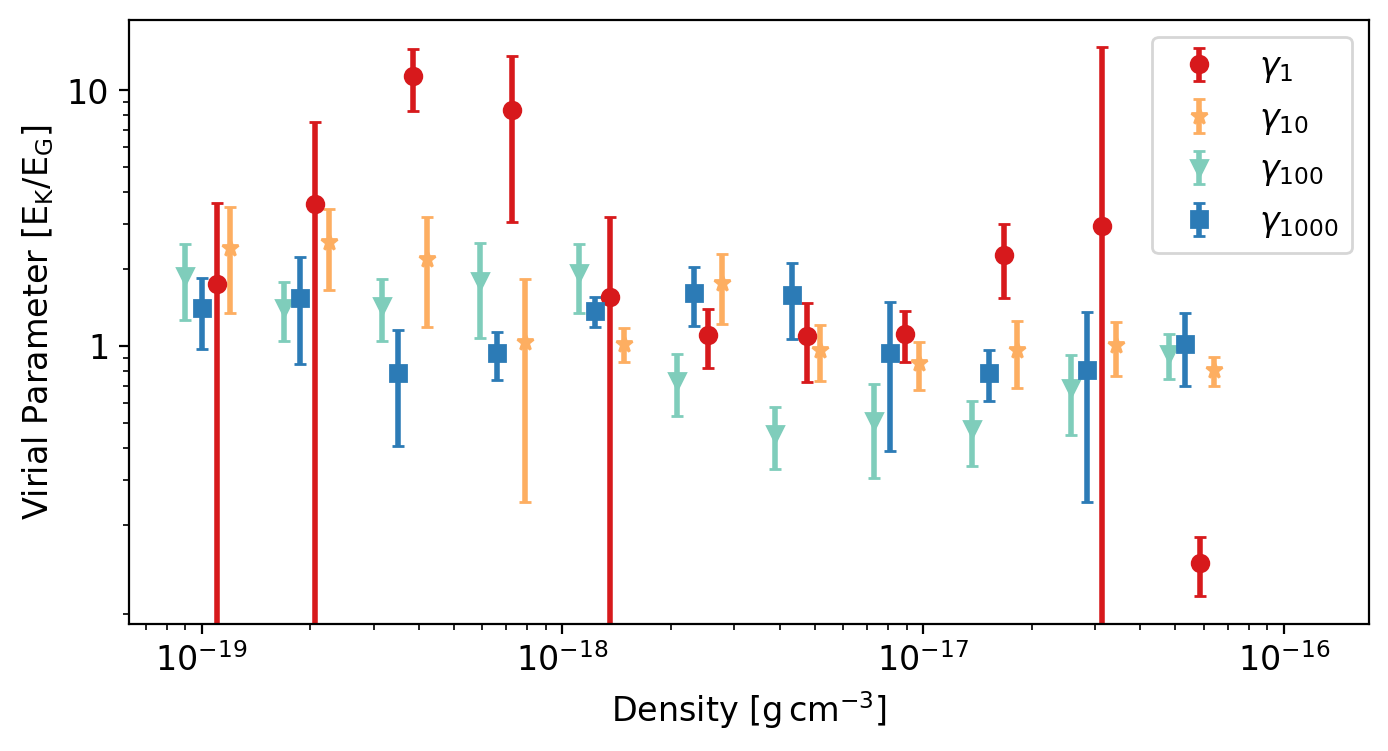

In [14]:
plt.figure(figsize=(8,4))
plt.errorbar(b1*1.1, v1, yerr=ve1, color=c.colours()[0], linewidth=2, capsize=2, linestyle="", marker="o", label="$\\gamma_{1}$")
plt.errorbar(b10*1.2, v10, yerr=ve10, color=c.colours()[1], linewidth=2, capsize=2, linestyle="", marker="*", label="$\\gamma_{10}$")
plt.errorbar(b100*0.9, v100, yerr=ve100, color=c.colours()[3], linewidth=2, capsize=2, linestyle="", marker="v", label="$\\gamma_{100}$")
plt.errorbar(b1000,v1000, yerr=ve1000, color=c.colours()[4], linewidth=2, capsize=2, linestyle="", marker="s", label="$\\gamma_{1000}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Density [$\\rm g \\, cm^{-3} $]")
plt.ylabel("Virial Parameter [$\\rm E_K / E_G$]")
plt.yticks([1, 10], ["1", "10"])
plt.legend()